<a href="https://colab.research.google.com/github/wildtulipan/Acetycholine-Striatal-Dynamics/blob/main/Preprocesado_Fotometria.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fiber Photomertry Data Processing
**Disclaimer:**
This notebooks contains the fiber photometry preprocessing pipeline intented for internal use of the the **F. Tecuapetla Lab** at UNAM, this pipeline is based on the *Simpson et al. (2024)* Nueron Primer paper, all of the preprocessing analysis excepts a RWD-Biosystems aquisition system output foler

Code By: Velázquez-Ruíz, Antonio (2025)

In [105]:
#@title Load Dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from scipy.optimize import curve_fit
from scipy.ndimage import uniform_filter1d
from scipy.stats import linregress


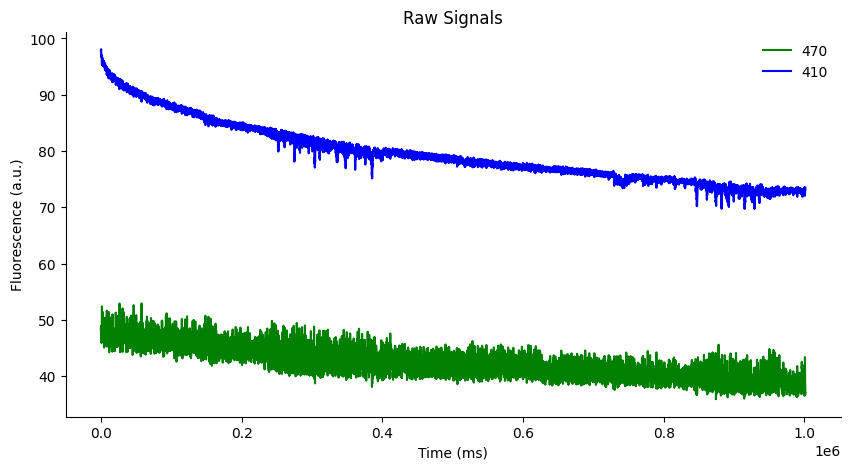

In [164]:
#@title Data Loader
fluorescence = pd.read_csv('Fluorescence-unaligned.csv') # Fluoresence-unaligned file
fluorescence_470 = np.array(fluorescence[fluorescence['Lights']==470]["Channel1"])
fluorescence_410 = np.array(fluorescence[fluorescence['Lights']==410]["Channel1"])
time_470 = np.array(fluorescence[fluorescence['Lights']==470]["TimeStamp"]) # Time(ms)
time_410 = np.array(fluorescence[fluorescence['Lights']==410]["TimeStamp"]) # Time(me)

# Plot raw data
plt.figure(figsize=(10, 5))
plt.plot(time_470, fluorescence_470, color="green", label="470")
plt.plot(time_410, fluorescence_410, color="blue", label="410")
plt.title('Raw Signals')
plt.ylabel('Fluorescence (a.u.)')
plt.xlabel('Time (ms)')
plt.legend(frameon=False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.show()

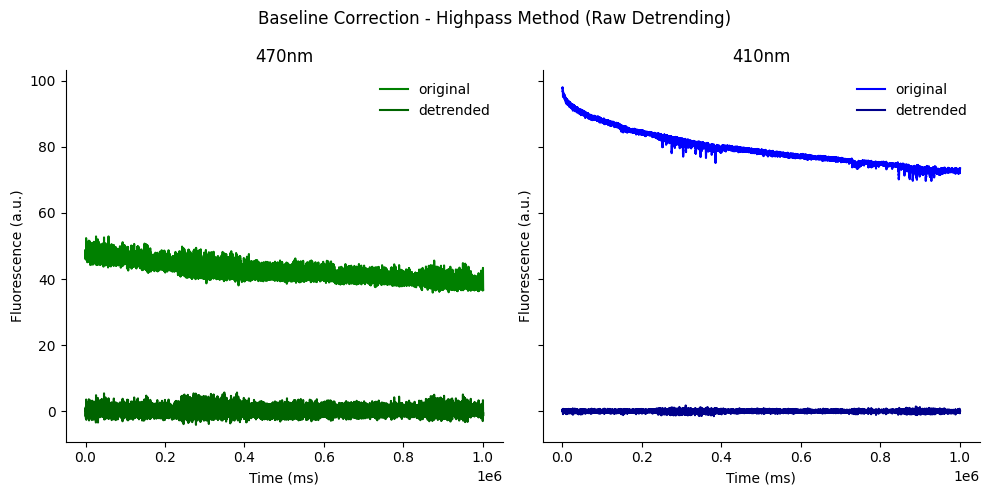

In [163]:
#@title Baseline Correction
method = "highpass" # [highpass, exponential, polynomial]
Fs = 15 # Sampling rate
poly_order = 15  # Polynomial order (adjust as needed: 1=linear, 2=quadratic, 3=cubic)
cutoff_freq = 0.5 # Highpass stopband


# Switch case for baseline correction methods
match method:
    case "highpass": # --------------------------------------------------------
        # Design Butterworth highpass filter
        nyquist = Fs / 2
        normalized_cutoff = cutoff_freq / nyquist
        order = 5  # Filter order (higher = steeper rolloff)

        # Create filter coefficients
        b, a = signal.butter(order, normalized_cutoff, btype='high', analog=False)

        # Apply filter
        detrended_470 = signal.filtfilt(b, a, fluorescence_470)  # Zero-phase filtering
        detrended_410 = signal.filtfilt(b, a, fluorescence_410)  # Zero-phase filtering

    case "exponential": # -----------------------------------------------------
        # Define double exponential decay function
        def double_exp(t, a1, b1, a2, b2, c):
            return a1 * np.exp(-b1 * t) + a2 * np.exp(-b2 * t) + c

        # Convert time to seconds
        time_470_sec = np.array(time_470) / 1000.0
        time_410_sec = np.array(time_410) / 1000.0

        # Initial guesses for 470nm
        c_470 = np.mean(fluorescence_470[-10:])
        total_amp_470 = fluorescence_470[0] - c_470
        time_span_470 = time_470_sec[-1] - time_470_sec[0]

        p0_470 = [0.7 * total_amp_470,  # a1 (fast amplitude)
                  3.0 / (0.2 * time_span_470),  # b1 (fast decay)
                  0.3 * total_amp_470,  # a2 (slow amplitude)
                  1.0 / (0.8 * time_span_470),  # b2 (slow decay)
                  c_470]  # c (baseline)

        # Similar for 410nm...
        c_410 = np.mean(fluorescence_410[-10:])
        total_amp_410 = fluorescence_410[0] - c_410
        time_span_410 = time_410_sec[-1] - time_410_sec[0]

        p0_410 = [0.7 * total_amp_410, 3.0 / (0.2 * time_span_410),
                  0.3 * total_amp_410, 1.0 / (0.8 * time_span_410), c_410]

        # Fit double exponentials
        popt_470, _ = curve_fit(double_exp, time_470_sec, fluorescence_470, p0=p0_470,
                                maxfev=10000)
        baseline_470 = double_exp(time_470_sec, *popt_470)
        detrended_470 = fluorescence_470 - baseline_470

        popt_410, _ = curve_fit(double_exp, time_410_sec, fluorescence_410, p0=p0_410,
                                maxfev=10000)
        baseline_410 = double_exp(time_410_sec, *popt_410)
        detrended_410 = fluorescence_410 - baseline_410

        # Preserve mean if requested
        if preserve_mean:
            detrended_470 = detrended_470 + np.mean(fluorescence_470)
            detrended_410 = detrended_410 + np.mean(fluorescence_410)

    case "polynomial": # ------------------------------------------------------
        # Convert time to seconds for better numerical stability
        time_470_sec = np.array(time_470) / 1000.0
        time_410_sec = np.array(time_410) / 1000.0

        # Fit polynomial to data
        poly_coeffs_470 = np.polyfit(time_470_sec, fluorescence_470, poly_order)
        baseline_470 = np.polyval(poly_coeffs_470, time_470_sec)
        detrended_470 = fluorescence_470 - baseline_470

        poly_coeffs_410 = np.polyfit(time_410_sec, fluorescence_410, poly_order)
        baseline_410 = np.polyval(poly_coeffs_410, time_410_sec)
        detrended_410 = fluorescence_410 - baseline_410

        # Preserve mean if requested
        if preserve_mean:
            detrended_470 = detrended_470 + np.mean(fluorescence_470)
            detrended_410 = detrended_410 + np.mean(fluorescence_410)

    case _: # Default case for unknown method
        print(f"Unknown method: {method}. Using highpass filter.")
        # Fallback to highpass
        nyquist = Fs / 2
        normalized_cutoff = cutoff_freq / nyquist
        order = 4
        b, a = signal.butter(order, normalized_cutoff, btype='high', analog=False)
        detrended_470 = signal.filtfilt(b, a, fluorescence_470)
        detrended_410 = signal.filtfilt(b, a, fluorescence_410)

        if preserve_mean:
            detrended_470 = detrended_470 + np.mean(fluorescence_470)
            detrended_410 = detrended_410 + np.mean(fluorescence_410)

# Plot it *********************************************************************
# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5),
                               sharex=True, sharey=True)

# Add supertitle with method name and preserve_mean status
mean_status = "Mean Preserved" if preserve_mean else "Raw Detrending"
plt.suptitle(f'Baseline Correction - {method.capitalize()} Method ({mean_status})')

# Plot on first subplot
ax1.set_title('470nm')
ax1.plot(time_470, fluorescence_470, color="green", label="original")
ax1.plot(time_470, detrended_470, color="darkgreen", label="detrended")
ax1.set_xlabel('Time (ms)')
ax1.set_ylabel('Fluorescence (a.u.)')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.legend(frameon=False)

# Plot on second subplot
ax2.set_title('410nm')
ax2.plot(time_410, fluorescence_410, color="blue", label="original")
ax2.plot(time_410, detrended_410, color="darkblue", label="detrended")
ax2.set_xlabel('Time (ms)')
ax2.set_ylabel('Fluorescence (a.u.)')
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.legend(frameon=False)

plt.tight_layout()
plt.show()

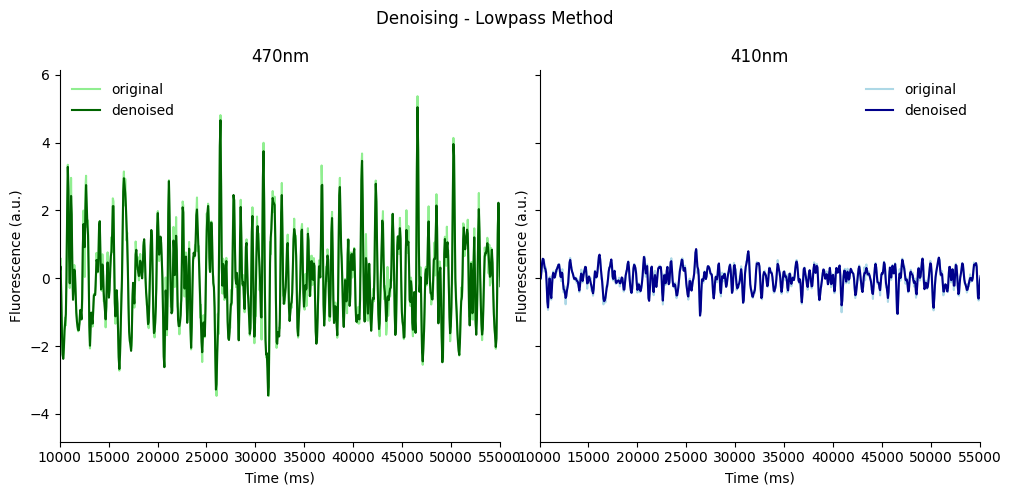

In [162]:
#@title Denoising
method = "lowpass" # [lowpass, smothing]
zoom_in = (10000,55000) # In miliseconds
Fs = 15 # Sampling rate
cutoff_freq = 4.0  # Cutoff frequency (Hz) - adjust based on your signal


# Switch case for denoising methods
match method:
    case "lowpass": # ---------------------------------------------------------
        # Design Butterworth lowpass filter
        nyquist = Fs / 2
        normalized_cutoff = cutoff_freq / nyquist
        order = 4  # Filter order (higher = steeper rolloff)

        # Create filter coefficients
        b, a = signal.butter(order, normalized_cutoff, btype='low', analog=False)

        # Apply filter
        denoised_470 = signal.filtfilt(b, a, detrended_470)  # Zero-phase filtering
        denoised_410 = signal.filtfilt(b, a, detrended_410)  # Zero-phase filtering

    case "smoothing": # -------------------------------------------------------
        # Smoothing parameters
        window_size = 5  # Adjust based on desired smoothing level (odd number)

        # Apply Savitzky-Golay filter for smooth denoising
        denoised_470 = signal.savgol_filter(detrended_470, window_size, polyorder=2)
        denoised_410 = signal.savgol_filter(detrended_410, window_size, polyorder=2)

        # Alternative: Moving average (uncomment to use instead)
        # denoised_470 = uniform_filter1d(detrended_470, size=window_size)
        # denoised_410 = uniform_filter1d(detrended_410, size=window_size)

    case _: # Default case for unknown method
        print(f"Unknown method: {method}. Using lowpass filter.")
        # Fallback to lowpass
        cutoff_freq = 2.0
        nyquist = Fs / 2
        normalized_cutoff = cutoff_freq / nyquist
        order = 4
        b, a = signal.butter(order, normalized_cutoff, btype='low', analog=False)
        denoised_470 = signal.filtfilt(b, a, detrended_470)
        denoised_410 = signal.filtfilt(b, a, detrended_410)

# Plot it *********************************************************************
# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5),
                               sharex=True, sharey=True)

# Add supertitle with method name
plt.suptitle(f'Denoising - {method.capitalize()} Method')

# Plot on first subplot
ax1.set_title('470nm')
ax1.plot(time_470, detrended_470, color="lightgreen", label="original")
ax1.plot(time_470, denoised_470, color="darkgreen", label="denoised")
ax1.set_xlim(zoom_in)
ax1.set_xlabel('Time (ms)')
ax1.set_ylabel('Fluorescence (a.u.)')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.legend(frameon=False)

# Plot on second subplot
ax2.set_title('410nm')
ax2.plot(time_410, detrended_410, color="lightblue", label="original")
ax2.plot(time_410, denoised_410, color="darkblue", label="denoised")
ax2.set_xlabel('Time (ms)')
ax2.set_ylabel('Fluorescence (a.u.)')
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.legend(frameon=False)

plt.tight_layout()
plt.show()

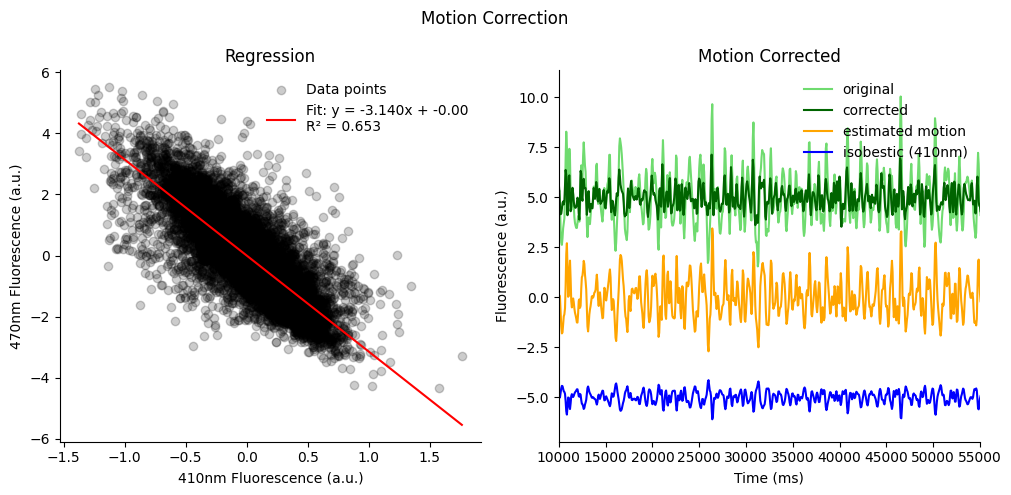

In [165]:
#@title Motion Correction
# Regresión lineal con numpy
slope, intercept, r_value, p_value, std_err = linregress(x=denoised_410, y=denoised_470)
est_motion_470 = intercept + (slope * denoised_410)
corrected_470 = denoised_470 - est_motion_470

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Add supertitle with method name
plt.suptitle('Motion Correction')

# Plot on first subplot - Regression
ax1.set_title('Regression')
ax1.scatter(denoised_410, denoised_470, color="black", alpha=0.2, label="Data points")

# Sort data for proper line plotting
sorted_indices = np.argsort(denoised_410)
ax1.plot(denoised_410[sorted_indices], est_motion_470[sorted_indices], color="red",
         label=f"Fit: y = {slope:.3f}x + {intercept:.2f}\nR² = {r_value**2:.3f}")

ax1.set_xlabel('410nm Fluorescence (a.u.)')
ax1.set_ylabel('470nm Fluorescence (a.u.)')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.legend(frameon=False)

# Plot on second subplot - Time series
ax2.set_title('Motion Corrected')
ax2.plot(time_410, denoised_470+5, color="limegreen", label="original", alpha=0.7)
ax2.plot(time_410, corrected_470+5, color="darkgreen", label="corrected")
ax2.plot(time_410, est_motion_470, color="orange", label="estimated motion")
ax2.plot(time_410, denoised_410-5, color="blue", label="isobestic (410nm)")

ax2.set_xlabel('Time (ms)')
ax2.set_ylabel('Fluorescence (a.u.)')
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.legend(frameon=False)

# Apply zoom to the correct subplot
ax2.set_xlim(zoom_in)

plt.tight_layout()
plt.show()

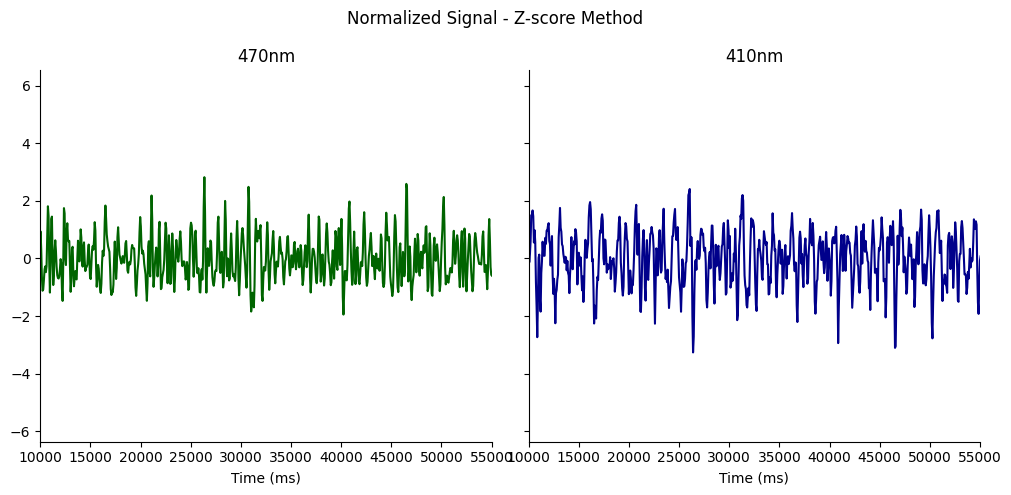

In [171]:
#@title Normalization
method = "z-score" # [z-score, df/F]

# Recover Means
mean_470 = np.mean(fluorescence_470)
mean_410 = np.mean(fluorescence_410)

match method:
    case "z-score": # -------------------------------------------------------
      corrected_470 = corrected_470 + mean_470
      norm_470 = (corrected_470 - np.mean(corrected_470)) / np.std(corrected_470)
      corrected_410 = detrended_410 + mean_410
      norm_410 = (detrended_410 - np.mean(detrended_410)) / np.std(detrended_410)

    case "df/F": # -----------------------------------------------------------
      corrected_470 = corrected_470 + mean_470
      norm_470 = corrected_470 / np.mean(corrected_470)
      corrected_410 = detrended_410 + mean_410
      norm_410 = detrended_410 / np.mean(detrended_410)

# Plot it *********************************************************************
# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5),
                               sharex=True, sharey=True)

# Add supertitle with method name and preserve_mean status
plt.suptitle(f'Normalized Signal - {method.capitalize()} Method')

# Plot on first subplot
ax1.set_title('470nm')
ax1.plot(time_470, norm_470, color="darkgreen")
ax1.set_xlabel('Time (ms)')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

# Plot on second subplot
ax2.set_title('410nm')
ax2.plot(time_410, norm_410, color="darkblue")
ax2.set_xlabel('Time (ms)')
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

plt.xlim(zoom_in)
plt.tight_layout()
plt.show()

